<a href="https://colab.research.google.com/github/jjrodcast/MaskDectector/blob/master/MaskDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir faceModels
!wget "https://drive.google.com/uc?export=download&id=1p1uJpg7ahlgTCXpccahxEQ0zb4TI_ODV" -O faceModels/haarcascade_eye.xml
!wget "https://drive.google.com/uc?export=download&id=1e1HsaR2R9Pb3Hh89_WK52DAm9kgNqBBs" -O faceModels/haarcascade_frontalface_default.xml

In [149]:
!pip install mtcnn
from mtcnn import MTCNN

     |████████████████████████████████| 2.3MB 3.4MB/s 


Using TensorFlow backend.


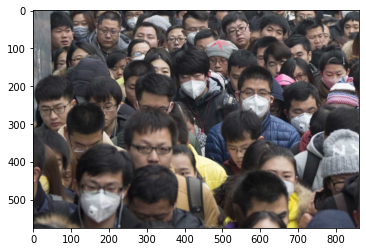

In [225]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
face_cascade = cv2.CascadeClassifier('faceModels/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('faceModels/haarcascade_eye.xml')
img = cv2.imread('test3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(gray, cmap='gray')
plt.imshow(img)

7


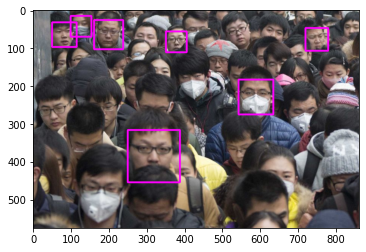

In [223]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
print(len(faces))
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),4)
plt.imshow(img)

35
{'box': [764, 142, 56, 67], 'confidence': 0.9999983310699463, 'keypoints': {'left_eye': (784, 171), 'right_eye': (810, 170), 'nose': (799, 188), 'mouth_left': (786, 196), 'mouth_right': (804, 196)}}
{'box': [258, 311, 111, 140], 'confidence': 0.9999977350234985, 'keypoints': {'left_eye': (293, 365), 'right_eye': (346, 367), 'nose': (319, 394), 'mouth_left': (296, 421), 'mouth_right': (338, 423)}}
{'box': [512, 28, 58, 64], 'confidence': 0.9999878406524658, 'keypoints': {'left_eye': (529, 55), 'right_eye': (554, 47), 'nose': (543, 62), 'mouth_left': (540, 81), 'mouth_right': (558, 76)}}
{'box': [169, 26, 55, 72], 'confidence': 0.9999634027481079, 'keypoints': {'left_eye': (187, 55), 'right_eye': (213, 57), 'nose': (200, 70), 'mouth_left': (187, 83), 'mouth_right': (209, 84)}}
{'box': [723, 50, 46, 56], 'confidence': 0.9999583959579468, 'keypoints': {'left_eye': (740, 74), 'right_eye': (760, 70), 'nose': (753, 84), 'mouth_left': (745, 96), 'mouth_right': (761, 93)}}
{'box': [547, 180,

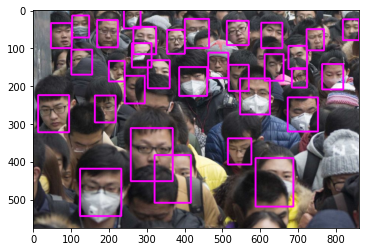

In [226]:
detector = MTCNN()
faces_mtcnn = detector.detect_faces(img_color)
print(len(faces_mtcnn))
for face in faces_mtcnn:
    print(face)
    bbox = face['box']
    confidence = face['confidence']
    (x, y, w, h) = bbox
    if confidence >= 0.95:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255), 4)
plt.imshow(img)